# We will try tracking the hands with just 1 landmark, which will be a 3 * 2 = 6 length vector for each time step. 

In [1]:
import cv2, os 
import numpy as np 

In [2]:
import mediapipe as mp 
from PIL import Image as im 
import mediapipe as mp

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    """Only give the 0th landmark"""

    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence)  
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 2
    Y_locations = [0] * 2
    Z_locations = [0] * 2
    if results.multi_hand_landmarks:
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                landmark = hand_landmark.landmark[i]
                X_locations[hand] = landmark.x
                Y_locations[hand] = landmark.y
                Z_locations[hand] = landmark.z
                break # take only the first landmark
            
    hands.close()
    return np.concatenate([X_locations, Y_locations, Z_locations]) 

In [3]:
"""read in all of the frames"""

SECONDS_TO_DETECT = 2 # in seconds

import os, cv2
from tqdm import tqdm 
import numpy as np

ARMFLAPPING_VIDEOS = []
CONTROL_VIDEOS = []
ARMFLAPPING_FPS = [] # store the FPS of all armflapping videos 
CONTROL_FPS = [] # store the FPS of all control videos 
for video_name in tqdm(os.listdir('behavior_data/manual_armflapping'), desc = "armflapping_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/manual_armflapping/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break  
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image) 
        
        ARMFLAPPING_VIDEOS.append(FRAMES)
        ARMFLAPPING_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")

for video_name in tqdm(os.listdir('behavior_data/manual_control'), desc = "control_videos"): 
    try: 
        cap = cv2.VideoCapture('behavior_data/manual_control/' + video_name)  
        frame_rate = cap.get(cv2.CAP_PROP_FPS)
        if cap.get(cv2.CAP_PROP_FRAME_COUNT) / frame_rate < SECONDS_TO_DETECT: continue # too short! 

        FRAMES = [] # frames for this video 

        while cap.isOpened(): 
            _, image = cap.read() 
            if not _ : 
                break 
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert to RGB. 
            FRAMES.append(image)
        
        CONTROL_VIDEOS.append(FRAMES)
        CONTROL_FPS.append(frame_rate)
    except Exception as e: 
        print(f"failed on {video_name}")
    
len(ARMFLAPPING_VIDEOS), len(CONTROL_VIDEOS)

armflapping_videos:  11%|█▏        | 7/61 [00:00<00:04, 12.87it/s]

failed on .DS_Store


control_videos:  28%|██▊       | 11/40 [00:00<00:01, 16.48it/s]

failed on .DS_Store


control_videos: 100%|██████████| 40/40 [00:04<00:00,  8.46it/s]


(60, 38)

In [4]:
# get the locations of all of the videos 

ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS = [], []
for FRAMES in tqdm(ARMFLAPPING_VIDEOS) :
    locs = []
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    ARMFLAPPING_LOCATIONS.append(locs)

for FRAMES in tqdm(CONTROL_VIDEOS):  
    locs = []
    for frame in FRAMES: 
        locs.append(hand_locations(frame))
    CONTROL_LOCATIONS.append(locs)

100%|██████████| 38/38 [02:03<00:00,  3.24s/it]


In [5]:
N = min([len(locs) for locs in [ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS]])
ARMFLAPPING_LOCATIONS = ARMFLAPPING_LOCATIONS[:N]
CONTROL_LOCATIONS = CONTROL_LOCATIONS[:N]
ARMFLAPPING_LOCATIONS = np.array(ARMFLAPPING_LOCATIONS)
CONTROL_LOCATIONS = np.array(CONTROL_LOCATIONS)

# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 6))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

padded_armflapping_locations = ARMFLAPPING_LOCATIONS
padded_control_locations = CONTROL_LOCATIONS
padded_armflapping_locations = pad(padded_armflapping_locations, maxlen = 90)
padded_control_locations = pad(padded_control_locations, maxlen = 90)
print(padded_control_locations.shape, padded_armflapping_locations.shape)
assert padded_armflapping_locations.shape == padded_control_locations.shape 

<ipython-input-5-381331460c32>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  ARMFLAPPING_LOCATIONS = np.array(ARMFLAPPING_LOCATIONS)
<ipython-input-5-381331460c32>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  CONTROL_LOCATIONS = np.array(CONTROL_LOCATIONS)
38it [00:00, 20073.50it/s]
38it [00:00, 31350.03it/s]

(38, 90, 6) (38, 90, 6)


In [6]:
from sklearn.model_selection import train_test_split

def generate_data(ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS): 
    ARMFLAPPING_LABELS = np.ones(ARMFLAPPING_LOCATIONS.shape[0])
    CONTROL_LABELS = np.zeros(CONTROL_LOCATIONS.shape[0])
    
    # concatenate 
    data = np.concatenate([ARMFLAPPING_LOCATIONS, CONTROL_LOCATIONS])
    labels = np.concatenate([ARMFLAPPING_LABELS, CONTROL_LABELS])
    
    return data, labels 
X, y = generate_data(padded_armflapping_locations, padded_control_locations)

In [7]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

def predict_on_video(model, path): 
    test_frames = []
    import cv2 

    cap = cv2.VideoCapture(path)

    while True: 
        _, frame = cap.read() 
        if not _: break 

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = hand_locations(frame)

        test_frames.append(frame)

    test_frames = np.array([test_frames])
    test_frames = pad(test_frames, maxlen = 90)
    
    return model.predict(np.array(test_frames))

In [8]:
import random 
import tensorflow as tf 
tf.config.run_functions_eagerly(True)

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :42] # [100, 42]
        Y_locations = X[:, 42:84] # [100, 42]
        Z_locations = X[:, 84:] # [100, 42]
        
        maximum = tf.math.reduce_max(Y_locations)
        minimum = tf.math.reduce_min(Y_locations)
        if maximum == 2: 
            # get the second highest 
            values, _ = tf.nn.top_k(tf.reshape(Y_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_up = 1 - maximum # the amount it can move up 
        can_move_down = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("up")
            # move up in this case 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:, 42:84].assign(X[:,42:84] + move_up)

        else: 
            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:, 42:84].assign(X[:,42:84]-move_down)

        maximum = tf.math.reduce_max(X_locations)
        minimum = tf.math.reduce_min(X_locations)
        
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(X_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            # create a set. 
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e: 
                maximum = 0 
            
        can_move_right = 1 - maximum 
        can_move_left = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            #print("right")
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :42].assign(X[:,:42]+move_right)
        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :42].assign(X[:,:42]-move_left)

        
        maximum = tf.math.reduce_max(Z_locations)
        minimum = tf.math.reduce_min(Z_locations)
        if maximum == 2: 
            values, _ = tf.nn.top_k(tf.reshape(Z_locations, -1), tf.shape(tf.reshape(X_locations, -1))[0])
            try: 
                values, _ = tf.unique(values)
                maximum = values[1]
            except Exception as e:  
                maximum = 0 
        
        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 84:].assign(X[:,84:]+move_far)
        else: 
            # move left 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 84:].assign(X[:,84:]-move_close)

        return X


class Augmenter(tf.keras.layers.Layer): 
    def __init__(self): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            return X
        else: 
            return X 


class TTAugmenter(tf.keras.layers.Layer): 
    def __init__(self): 
        super().__init__()
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        
    def call(self, X):
        return tf.map_fn(_shift, X)
        
        

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


Epoch 1/100
2/2 [==============================] - 1s 336ms/step - loss: 0.6988 - accuracy: 0.4667 - val_loss: 0.6969 - val_accuracy: 0.3750
Epoch 2/100
2/2 [==============================] - 1s 278ms/step - loss: 0.6929 - accuracy: 0.5167 - val_loss: 0.6993 - val_accuracy: 0.3750
Epoch 3/100
2/2 [==============================] - 1s 313ms/step - loss: 0.6889 - accuracy: 0.5167 - val_loss: 0.6982 - val_accuracy: 0.3750
Epoch 4/100
2/2 [==============================] - 1s 319ms/step - loss: 0.6805 - accuracy: 0.5333 - val_loss: 0.6973 - val_accuracy: 0.3750
Epoch 5/100
2/2 [==============================] - 1s 340ms/step - loss: 0.6762 - accuracy: 0.5333 - val_loss: 0.6969 - val_accuracy: 0.3750
Epoch 6/100
2/2 [==============================] - 1s 332ms/step - loss: 0.6749 - accuracy: 0.5333 - val_loss: 0.6956 - val_accuracy: 0.3750
Epoch 7/100
2/2 [==============================] - 1s 335ms/step - loss: 0.6723 - accuracy: 0.5333 - val_loss: 0.6913 - val_accuracy: 0.3750
Epoch 8/100
2

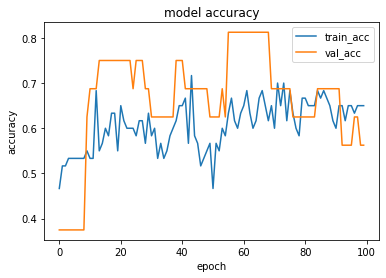

2/2 [==============================] - 0s 54ms/step - loss: 0.5917 - accuracy: 0.6500
evaluation on training data w/o augs:  [0.5917279720306396, 0.6499999761581421]
1/1 [==============================] - 0s 58ms/step - loss: 0.7473 - accuracy: 0.5625
evaluation on testing data:  [0.7473346590995789, 0.5625]


In [9]:
model = tf.keras.models.Sequential([
    Augmenter(), 
    tf.keras.layers.LSTM(64, return_sequences = False), 
    tf.keras.layers.Dense(1, activation = "sigmoid")
])

model.compile(loss = "binary_crossentropy", optimizer = "Adam", metrics = ['accuracy'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 100)

plot(history)

print("evaluation on training data w/o augs: ", model.evaluate(X_train, y_train))
print('evaluation on testing data: ', model.evaluate(X_test, y_test))

In [10]:
# high validation accuracy 
# but not high testing accuracy


In [11]:
for video_name in os.listdir("behavior_data/shorter_armflapping"): 
    if video_name == ".DS_Store": continue
    print(f"for video {video_name} you get : " , predict_on_video(model, "behavior_data/shorter_armflapping/" + video_name))

1it [00:00, 19972.88it/s]


for video _75.mp4 you get :  [[0.10913846]]


1it [00:00, 3313.04it/s]


for video _61.mp4 you get :  [[0.46527064]]


1it [00:00, 18893.26it/s]


for video _49.mp4 you get :  [[0.57098794]]


1it [00:00, 20460.02it/s]


for video _48.mp4 you get :  [[0.5158095]]


1it [00:00, 22192.08it/s]


for video _60.mp4 you get :  [[0.49698985]]


1it [00:00, 22795.13it/s]


for video _74.mp4 you get :  [[0.10408074]]


1it [00:00, 4999.17it/s]


for video _76.mp4 you get :  [[0.5299541]]


1it [00:00, 20763.88it/s]


for video _89.mp4 you get :  [[0.54143274]]


1it [00:00, 18477.11it/s]


for video _88.mp4 you get :  [[0.5722669]]


1it [00:00, 2409.13it/s]


for video _77.mp4 you get :  [[0.4435098]]


1it [00:00, 1912.59it/s]


for video _63.mp4 you get :  [[0.37396872]]


1it [00:00, 2501.08it/s]


for video _67.mp4 you get :  [[0.38873085]]


1it [00:00, 2325.00it/s]


for video _73.mp4 you get :  [[0.35669005]]


1it [00:00, 20460.02it/s]


for video _98.mp4 you get :  [[0.5253968]]


1it [00:00, 20460.02it/s]


for video _99.mp4 you get :  [[0.5304952]]


1it [00:00, 19599.55it/s]


for video _72.mp4 you get :  [[0.5279027]]


1it [00:00, 5178.15it/s]


for video _66.mp4 you get :  [[0.5354068]]


1it [00:00, 19239.93it/s]


for video _64.mp4 you get :  [[0.46423805]]


1it [00:00, 20867.18it/s]


for video _65.mp4 you get :  [[0.1032123]]


1it [00:00, 2709.50it/s]


for video _71.mp4 you get :  [[0.45599824]]


1it [00:00, 18893.26it/s]


for video _1.mp4 you get :  [[0.5376679]]


1it [00:00, 14563.56it/s]


for video _104.mp4 you get :  [[0.543675]]


1it [00:00, 20262.34it/s]


for video _110.mp4 you get :  [[0.5469027]]


1it [00:00, 18893.26it/s]


for video _16.mp4 you get :  [[0.5096191]]


1it [00:00, 18477.11it/s]


for video _17.mp4 you get :  [[0.51502365]]


1it [00:00, 18157.16it/s]


for video _111.mp4 you get :  [[0.5452379]]


1it [00:00, 19972.88it/s]


for video _105.mp4 you get :  [[0.52796537]]


1it [00:00, 16912.52it/s]


for video _0.mp4 you get :  [[0.50863737]]


1it [00:00, 18893.26it/s]


for video _2.mp4 you get :  [[0.5839442]]


1it [00:00, 22310.13it/s]


for video _113.mp4 you get :  [[0.57018226]]


1it [00:00, 19239.93it/s]


for video _107.mp4 you get :  [[0.54143536]]


1it [00:00, 17848.10it/s]


for video _29.mp4 you get :  [[0.5315732]]


1it [00:00, 22671.91it/s]


for video _28.mp4 you get :  [[0.59188706]]


1it [00:00, 17189.77it/s]


for video _14.mp4 you get :  [[0.5602998]]


1it [00:00, 21290.88it/s]


for video _106.mp4 you get :  [[0.50967145]]


1it [00:00, 18893.26it/s]


for video _112.mp4 you get :  [[0.5087969]]


1it [00:00, 21732.15it/s]


for video _3.mp4 you get :  [[0.58448505]]


1it [00:00, 18893.26it/s]


for video _102.mp4 you get :  [[0.55971795]]


1it [00:00, 18477.11it/s]


for video _7.mp4 you get :  [[0.5149864]]


1it [00:00, 17924.38it/s]


for video _38.mp4 you get :  [[0.51541024]]


1it [00:00, 19239.93it/s]


for video _10.mp4 you get :  [[0.57218397]]


1it [00:00, 18157.16it/s]


for video _11.mp4 you get :  [[0.59960514]]


1it [00:00, 15363.75it/s]


for video _39.mp4 you get :  [[0.5136519]]


1it [00:00, 20460.02it/s]


for video _6.mp4 you get :  [[0.4937176]]


1it [00:00, 1470.65it/s]


for video _103.mp4 you get :  [[0.420565]]


1it [00:00, 19239.93it/s]


for video _101.mp4 you get :  [[0.51811343]]


1it [00:00, 16644.06it/s]


for video _115.mp4 you get :  [[0.53021324]]


1it [00:00, 13357.66it/s]


for video _4.mp4 you get :  [[0.5760237]]


1it [00:00, 1399.03it/s]


for video _13.mp4 you get :  [[0.43632385]]


1it [00:00, 2032.12it/s]


for video _12.mp4 you get :  [[0.3857831]]


1it [00:00, 15141.89it/s]


for video _5.mp4 you get :  [[0.56943905]]


1it [00:00, 18893.26it/s]


for video _114.mp4 you get :  [[0.46630272]]


1it [00:00, 18558.87it/s]


for video _100.mp4 you get :  [[0.5242681]]


1it [00:00, 2128.01it/s]


for video _8.mp4 you get :  [[0.43381855]]


1it [00:00, 2078.45it/s]


for video _37.mp4 you get :  [[0.37312973]]


1it [00:00, 937.27it/s]


for video _23.mp4 you get :  [[0.39357165]]


1it [00:00, 22795.13it/s]


for video _22.mp4 you get :  [[0.5292746]]


1it [00:00, 3358.13it/s]


for video _36.mp4 you get :  [[0.5072041]]


1it [00:00, 2398.12it/s]


for video _9.mp4 you get :  [[0.47316507]]


1it [00:00, 19599.55it/s]


for video _20.mp4 you get :  [[0.0759432]]


1it [00:00, 20360.70it/s]


for video _34.mp4 you get :  [[0.15366152]]


1it [00:00, 18157.16it/s]


for video _35.mp4 you get :  [[0.24429482]]


1it [00:00, 17848.10it/s]


for video _21.mp4 you get :  [[0.07825002]]


1it [00:00, 2403.61it/s]


for video _19.mp4 you get :  [[0.3887849]]


1it [00:00, 18236.10it/s]


for video _25.mp4 you get :  [[0.5716601]]


1it [00:00, 18157.16it/s]


for video _31.mp4 you get :  [[0.5027795]]


1it [00:00, 18157.16it/s]


for video _30.mp4 you get :  [[0.13082388]]


1it [00:00, 18558.87it/s]


for video _24.mp4 you get :  [[0.5450418]]


1it [00:00, 4419.71it/s]


for video _18.mp4 you get :  [[0.46888575]]


1it [00:00, 21732.15it/s]


for video _108.mp4 you get :  [[0.5498684]]


1it [00:00, 3775.25it/s]


for video _32.mp4 you get :  [[0.51278186]]


1it [00:00, 4350.94it/s]


for video _26.mp4 you get :  [[0.49513263]]


1it [00:00, 2132.34it/s]


for video _27.mp4 you get :  [[0.44607675]]


1it [00:00, 1769.75it/s]


for video _33.mp4 you get :  [[0.44311804]]


1it [00:00, 18893.26it/s]


for video _109.mp4 you get :  [[0.5568544]]


1it [00:00, 2046.00it/s]


for video _54.mp4 you get :  [[0.38770685]]


1it [00:00, 3390.71it/s]


for video _40.mp4 you get :  [[0.48645446]]


1it [00:00, 4165.15it/s]


for video _68.mp4 you get :  [[0.477009]]


1it [00:00, 17772.47it/s]


for video _97.mp4 you get :  [[0.5140295]]


1it [00:00, 17189.77it/s]


for video _83.mp4 you get :  [[0.08552867]]


1it [00:00, 16131.94it/s]


for video _82.mp4 you get :  [[0.6269958]]


1it [00:00, 17924.38it/s]


for video _96.mp4 you get :  [[0.55748594]]


1it [00:00, 1072.71it/s]


for video _41.mp4 you get :  [[0.30025232]]


1it [00:00, 1536.38it/s]


for video _55.mp4 you get :  [[0.35054827]]


1it [00:00, 2468.69it/s]


for video _43.mp4 you get :  [[0.4028133]]


1it [00:00, 2809.31it/s]


for video _80.mp4 you get :  [[0.5318231]]


1it [00:00, 14315.03it/s]


for video _94.mp4 you get :  [[0.53942364]]


1it [00:00, 19972.88it/s]


for video _95.mp4 you get :  [[0.59910333]]


1it [00:00, 2083.61it/s]


for video _81.mp4 you get :  [[0.4410587]]


1it [00:00, 2037.06it/s]


for video _42.mp4 you get :  [[0.50823635]]


1it [00:00, 1245.34it/s]


for video _46.mp4 you get :  [[0.39527777]]


1it [00:00, 2193.67it/s]


for video _52.mp4 you get :  [[0.5073665]]


1it [00:00, 19972.88it/s]


for video _85.mp4 you get :  [[0.44092232]]


1it [00:00, 2032.12it/s]


for video _91.mp4 you get :  [[0.4003163]]


1it [00:00, 20763.88it/s]


for video _90.mp4 you get :  [[0.5825698]]


1it [00:00, 14926.35it/s]


for video _84.mp4 you get :  [[0.5655873]]


1it [00:00, 16980.99it/s]


for video _53.mp4 you get :  [[0.5482504]]


1it [00:00, 1379.71it/s]


for video _47.mp4 you get :  [[0.07893607]]


1it [00:00, 18558.87it/s]


for video _51.mp4 you get :  [[0.55389154]]


1it [00:00, 1392.99it/s]


for video _45.mp4 you get :  [[0.44295594]]


1it [00:00, 2801.81it/s]


for video _92.mp4 you get :  [[0.44816923]]


1it [00:00, 3890.82it/s]


for video _86.mp4 you get :  [[0.40619785]]


1it [00:00, 3802.63it/s]


for video _87.mp4 you get :  [[0.40304312]]


1it [00:00, 1035.37it/s]


for video _93.mp4 you get :  [[0.46302724]]


1it [00:00, 3472.11it/s]


for video _44.mp4 you get :  [[0.51614267]]


1it [00:00, 18808.54it/s]


for video _50.mp4 you get :  [[0.49365678]]


1it [00:00, 4306.27it/s]

for video _78.mp4 you get :  [[0.53514683]]
